Set up environment variable

In [1]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='1'

Install MMCV using MIM

In [ ]:
%pip install -U openmim
!mim install mmcv-full

Install MMDetection

In [ ]:
!git clone https://github.com/open-mmlab/mmdetection.git
%cd mmdetection
%pip install -v -e .
# "-v" means verbose, or more output
# "-e" means installing a project in editable mode,
# thus any local modifications made to the code will take effect without reinstallation.

Check installation

In [2]:
# Check Pytorch installation
import torch
print(torch.__version__, torch.cuda.is_available())

# Check MMDetection installation
import mmdet
print(mmdet.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print(get_compiling_cuda_version())
print(get_compiler_version())

1.13.1+cu117 True
2.28.2
11.7
GCC 9.3


/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


Install COCO pretrained weights

In [ ]:
!mkdir checkpoints
!wget -c https://download.openmmlab.com/mmdetection/v2.0/deformable_detr/deformable_detr_r50_16x2_50e_coco/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth -O checkpoints/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth

Imports

In [3]:
import mmcv
#import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from mmcv import Config
from mmdet.apis import set_random_seed
from mmdet.datasets import build_dataset
from mmdet.datasets import build_dataloader
from mmdet.models import build_detector
from mmdet.apis import train_detector
from mmdet.apis import inference_detector
from mmdet.apis import init_detector
from mmdet.apis import show_result_pyplot
import os.path as osp
import seaborn as sns
from sklearn import metrics
import json
from pycocotools.coco import COCO
import numpy as np
from mmdet.core.bbox import bbox_overlaps

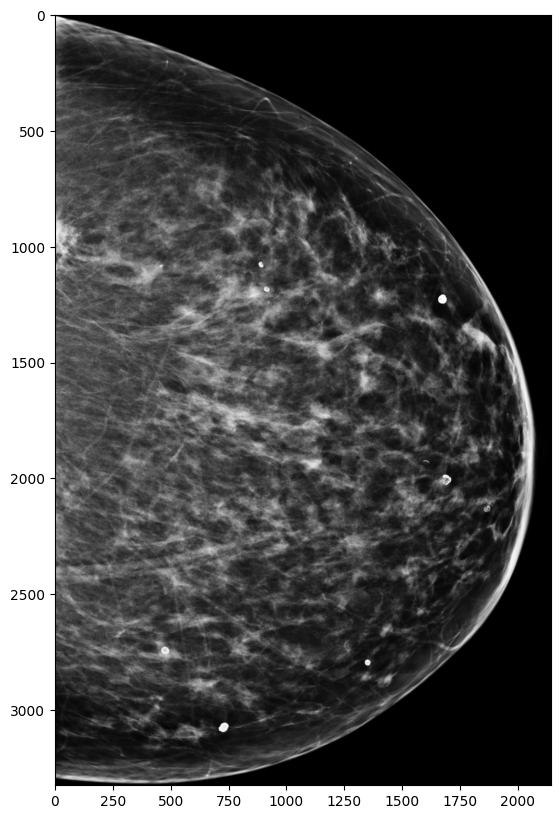

In [4]:
# Let's take a look at the dataset image
img = mmcv.imread('Dataset/training_images/demd1000_9962_1.2.826.0.1.3680043.9.3218.1.1.281768.8536.1510351239985.10145.0_CC.png')
plt.figure(figsize=(15, 10))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

Modify the config

In [4]:
cfg = Config.fromfile('/home/habtamu/MMDetection/mmdetection/configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py')

# Modify dataset type and path
cfg.dataset_type = 'COCODataset'

cfg.data.test.ann_file = '/home/habtamu/MMDetection/Dataset/validation_images/validation_annotations_modified.json'
cfg.data.test.img_prefix = '/home/habtamu/MMDetection/Dataset/validation_images/'
cfg.data.test.classes = ('lesion',)

cfg.data.train.ann_file = '/home/habtamu/MMDetection/Dataset/training_images/training_annotations_modified.json'
cfg.data.train.img_prefix = '/home/habtamu/MMDetection/Dataset/training_images/'
cfg.data.train.classes = ('lesion',)

cfg.data.val.ann_file = '/home/habtamu/MMDetection/Dataset/validation_images/validation_annotations_modified.json'
cfg.data.val.img_prefix = '/home/habtamu/MMDetection/Dataset/validation_images/'
cfg.data.val.classes = ('lesion',)

# modify num classes of the model in box head
cfg.model.bbox_head.num_classes = 1

# We can load the pre-trained DDETR model to obtain a higher performance
cfg.load_from = 'checkpoints/deformable_detr_r50_16x2_50e_coco_20210419_220030-a12b9512.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/home/habtamu/MMDetection/output/'

# The original learning rate (LR) is set for 8-GPU training.
# We divide it by 8 since we only use one GPU.
cfg.optimizer.lr = 0.02 / 8
cfg.lr_config.warmup = None
cfg.log_config.interval = 10

# Change the evaluation metric since we use customized dataset.
#cfg.evaluation.metric = 'mAP'

# Epochs
cfg.runner.max_epochs = 12

# We can set the evaluation interval to reduce the evaluation times
cfg.evaluation.interval = 12

# We can set the checkpoint saving interval to reduce the storage cost
cfg.checkpoint_config.interval = 12

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.device = 'cuda'
cfg.gpu_ids = range(1)

# We can also use tensorboard to log the training process
cfg.log_config.hooks = [
    dict(type='TextLoggerHook'),
    dict(type='TensorboardLoggerHook')]

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'COCODataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='AutoAugment',
        policies=[[{
            'type':
            'Resize',
            'img_scale': [(480, 1333), (512, 1333), (544, 1333), (576, 1333),
                          (608, 1333), (640, 1333), (672, 1333), (704, 1333),
                          (736, 1333), (768, 1333), (800, 1333)],
            'multiscale_mode':
            'value',
            'keep_ratio':
            True
        }],
                  [{
                      'type': 'Resize',
                      'img_scale': [(400, 4200), (500, 4200), (600, 4200)],
                      'multiscale_mode': 'value',
                      'keep_ratio': True
                  }, {
        

Train a new detector

In [ ]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

Understand the log

In [ ]:
# load tensorboard in colab
%load_ext tensorboard

# see curves in tensorboard
%tensorboard --logdir ./output

Test the trained detector on a single image

In [ ]:
img = mmcv.imread('Dataset/validation_images/demd101220_9960_1.2.826.0.1.3680043.9.3218.1.1.41483141.5414.1541746638844.174.0_MLO.png')
model.cfg = cfg
result = inference_detector(model, img)

# The default confidence probability threshold is 0.3
# Show_result_pyplot(model, img, result) 
show_result_pyplot(model, img, result, score_thr=0.1)

# Visualize the results in a new window
model.show_result(img, result)

# or save the visualization results to image files
model.show_result(img, result, out_file='result.png')

Save config to the file

In [6]:
config_file = '/home/habtamu/MMDetection/mmdetection/configs/deformable_detr/deformable_detr_r50_16x2_50e_coco.py'
meta = dict()
meta['exp_name'] = osp.basename(config_file)
print(meta)

# dump config
cfg.dump(osp.join("my_configs", meta['exp_name']))

{'exp_name': 'deformable_detr_r50_16x2_50e_coco.py'}


Inference

* Get results by using inference_detector

In [4]:
dumped_config_file = 'my_configs/deformable_detr_r50_16x2_50e_coco_28.py'
checkpoint_file = 'output/latest_28.pth'
model = init_detector(dumped_config_file, checkpoint_file, device='cuda')

load checkpoint from local path: output/latest_28.pth


In [6]:
# Load the validation dataset
val_dataset = build_dataset(cfg.data.val)
data_loader = build_dataloader(
    val_dataset,
    samples_per_gpu=1,
    workers_per_gpu=cfg.data.workers_per_gpu,
    dist=False,
    shuffle=False)

# Make predictions on the validation dataset
results = []
for batch in data_loader:
    #print(batch.keys())
    img_metas = batch['img_metas'][0].data[0]
    img_filename = img_metas[0]['filename']
    img  = mmcv.imread(img_filename)
    result = inference_detector(model, img)
    results.append(result)

# Save the predictions to a file
mmcv.dump(results, 'results/result_28.pkl')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


/home/habtamu/MMDetection/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(
/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


* Get results by using test.py

In [ ]:
# The arguments are the dumped config, the weightsd, and the output file path
!python mmdetection/tools/test.py my_configs/deformable_detr_r50_16x2_50e_coco_default_28.py output/latest_28.pth --out results/result_28_test.pkl --eval bbox

Log Analysis

In [9]:
# %cd mmdetection
# !python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve output/log_28.json --keys loss_bbox --legend loss_bbox
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve output/log_28.json --keys loss_cls loss_bbox --legend loss_cls loss_bbox --out plots/losses_28.pdf

plot curve of output/log_28.json, metric is loss_cls
plot curve of output/log_28.json, metric is loss_bbox
save curve to: plots/losses_28.pdf


* Compare the bbox mAP of two runs in the same figure.

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_logs.py plot_curve output/log_default.json output/log_28.json --keys bbox_mAP --legend run_default run_28 --out plots/loss_comparison.pdf

Result Analysis

* Visualize the results, save images to the directory images/

In [ ]:
# mmdetection/tools/analysis_tools/analyze_results.py calculates single image mAP and saves or shows 
# the topk images with the highest and lowest scores based on prediction results.
# the arguments are the dumped config, prediction result, directory to save images, and the request to show painted images
# the number of saved images will be 20 (the default value)
# the confidence probability threshold will be 0 (the default value) 
!python mmdetection/tools/analysis_tools/analyze_results.py \
       my_configs/deformable_detr_r50_16x2_50e_coco_28.py \
       results/result_28.pkl \
       images \
       --show

* Specify topk to 50 and save images to the directory images/

In [ ]:
!python mmdetection/tools/analysis_tools/analyze_results.py \
       my_configs/deformable_detr_r50_16x2_50e_coco_28.py \
       results/result_28.pkl \
       images \
       --topk 50

* Filter the low score prediction results

In [12]:
!python mmdetection/tools/analysis_tools/analyze_results.py \
       my_configs/deformable_detr_r50_16x2_50e_coco_28.py \
       results/result_28_test.pkl \
       images \
       --show-score-thr 0.3

/home/habtamu/venv-habtamuenv/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 724/724, 8.0 task/s, elapsed: 91s, ETA:     0s

### Custom Evaluation

Get ground-truth bounding boxes

In [3]:
# Load the validation annotations
ann_file = '/home/habtamu/MMDetection/Dataset/validation_images/validation_annotations_modified.json'
coco = COCO(ann_file)

# Get the category ID for the "lesion" class
cat_id = coco.getCatIds(catNms=['lesion'])[0]

# Get the IDs of all images in the validation set
img_ids = coco.getImgIds()

gt_bboxes = []

# Loop over all images and extract the ground-truth bounding boxes
for img_id in img_ids:
    # Load the image information
    img_info = coco.loadImgs(img_id)[0]

    # Load the annotations for this image
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
    anns = coco.loadAnns(ann_ids)

    # Extract the bounding boxes for this image
    bboxes = []
    for ann in anns:
        bbox = ann['bbox'] # In format [x,y,width,height]
        bbox = [bbox[0], bbox[1], bbox[0]+bbox[2], bbox[1]+bbox[3]] # Convert to format [xmin,ymin,xmax,ymax]
        bboxes.append(bbox)
    
    # Bounding boxes for all validation images
    gt_bboxes.append(bboxes)    

loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


Non-maximum Suppression

In [4]:
def apply_nms(results, iou_threshold):
    filtered_predictions = []
    for k in range(len(results)):
        preds = np.squeeze(np.array(results[k]))
        keep = [True] * len(preds)
        for i in range(len(preds)):
            if keep[i]:
                for j in range(i + 1, len(preds)):
                    if keep[j]:
                        pred_box_i = preds[i][:4]
                        pred_box_j = preds[j][:4]
                        pred_box_tensor_i = torch.tensor([pred_box_i[0],pred_box_i[1],pred_box_i[2],pred_box_i[3]])
                        pred_box_tensor_j = torch.tensor([pred_box_j[0],pred_box_j[1],pred_box_j[2],pred_box_j[3]])
                        iou = bbox_overlaps(pred_box_tensor_i.unsqueeze(0), pred_box_tensor_j.unsqueeze(0), mode='iou', is_aligned=False)
                        if iou.item() >= iou_threshold:
                            keep[j] = False
        filtered_preds = [pred for pred, keep_pred in zip(preds, keep) if keep_pred]
        combined_preds = np.array(filtered_preds)
        filtered_predictions.append(combined_preds)
    return filtered_predictions

In [7]:
# Load the predicted boxes from the results.pkl file
results = mmcv.load('results/result_default_28_test.pkl')
filtered_predictions= apply_nms(results, iou_threshold=0.05)

TPR vs IoU

In [8]:
post_processed = True

In [19]:
tp = np.zeros(99)
fp = np.zeros(99)
fn = np.zeros(99)
tpr = []

#thresholds = np.linspace(0, 1, 100)
# I divide values in the range [0,1] into 100 IOU thresholds
# But there is no true positive at IOU of zero
# Therefore, I started from 0.01010101 and divide values in the range [0.01010101,1] into 99 IOU thresholds
thresholds = np.linspace(0.01010101, 1, 99)

for i in range(len(gt_bboxes)):
    anns = np.squeeze(np.array(gt_bboxes[i]))
    if post_processed:
        preds = np.squeeze(np.array(filtered_predictions[i]))
    else:
        preds = np.squeeze(np.array(results[i]))

    # False positives array of size (99, number of predicted boxes)
    # If the predicted box is false positive at threshold k, 
    # the value of false_positives_arr[k, pred_box_index] will be 1.
    # Otherwise, it is zero.
    rows, cols = preds.shape
    false_positives_arr = np.zeros((99, rows))
    true_positives_arr = np.zeros((99, rows))
    for j in range(rows):
        score = preds[j][4]
        pred_box = preds[j][:4]
        
        pred_box_tensor = torch.tensor([pred_box[0],pred_box[1],pred_box[2],pred_box[3]])
        anns_tensor = torch.tensor([anns[0],anns[1],anns[2],anns[3]])
        iou = bbox_overlaps(pred_box_tensor.unsqueeze(0), anns_tensor.unsqueeze(0), mode='iou', is_aligned=False)
        #print("IoU:", iou.item())
        k = 0
        for threshold in thresholds:
            if iou.item() >= threshold:
                tp[k] = tp[k]+1
                true_positives_arr[k][j] = 1
            else:
                fp[k] = fp[k]+1
                false_positives_arr[k][j] = 1
            k = k + 1
    t = 0
    for thresh in thresholds:
        num_ones = np.sum(true_positives_arr[t] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[t] = tp[t] - false_pos
            fp[t] = fp[t] + false_pos

        if rows==0: # If there is no predicted box
            fn[t] = fn[t]+1
        elif rows==1: # If there is only one predicted box
            if false_positives_arr[t][0] == 1:
                fn[t] = fn[t]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[t] == false_positives_arr[t][0]) and false_positives_arr[t][0] == 1: 
                fn[t] = fn[t]+1
        t = t + 1

for l in range(99): 
    tpr.append(tp[l] / (tp[l] + fn[l])) 

TPR at the IoU threshold of 0.1

In [20]:
# Find index of IOU value closest to 0.1
iou_index = np.abs(thresholds - 0.1).argmin()

# Get corresponding TPR value
tpr_at_01_iou = tpr[iou_index]

print("TPR value for IoU of 0.1 is:", tpr_at_01_iou)

TPR value for IoU of 0.1 is: 0.9861878453038674


TPR-IoU Curve

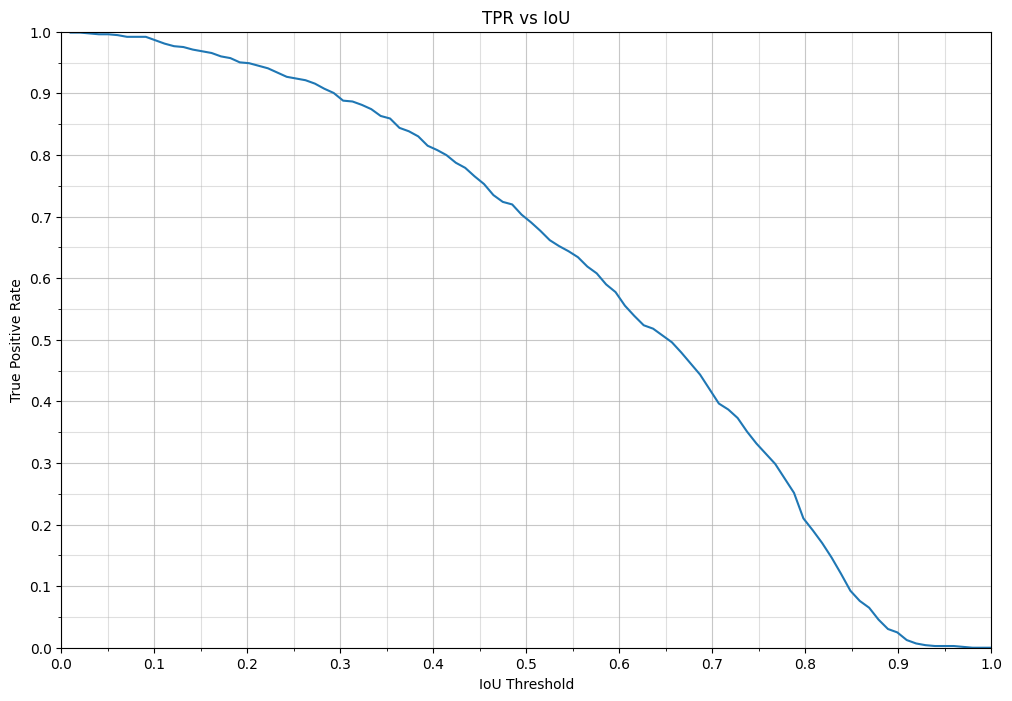

In [21]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(thresholds, tpr)
plt.xlabel("IoU Threshold")
plt.ylabel("True Positive Rate")
plt.title("TPR vs IoU")
plt.show()

TPR vs FPpI

In [9]:
tp = np.zeros(100)
fp = np.zeros(100)
fn = np.zeros(100)
tpr = []
FPpI = []

#confidence_scores = np.linspace(0.01, 1, 100)
confidence_scores = np.linspace(0, 1, 100)
IoU_thresh = 0.1

# Load the predicted boxes from the results.pkl file
results = mmcv.load('results/result_default_28_test.pkl')
for i in range(len(gt_bboxes)):
    anns = np.squeeze(np.array(gt_bboxes[i]))
    if post_processed:
        preds = np.squeeze(np.array(filtered_predictions[i]))
    else:
        preds = np.squeeze(np.array(results[i]))

    rows, cols = preds.shape
    false_positives_arr = np.zeros((100, rows))
    true_positives_arr = np.zeros((100, rows))

    for j in range(rows):
        score = preds[j][4]
        pred_box = preds[j][:4]
        
        pred_box_tensor = torch.tensor([pred_box[0],pred_box[1],pred_box[2],pred_box[3]])
        anns_tensor = torch.tensor([anns[0],anns[1],anns[2],anns[3]])
        iou = bbox_overlaps(pred_box_tensor.unsqueeze(0), anns_tensor.unsqueeze(0), mode='iou', is_aligned=False)

        k = 0
        for conf_score in confidence_scores:
            if score >= conf_score:
                if iou.item() >= IoU_thresh:
                    tp[k] = tp[k]+1
                    true_positives_arr[k][j] = 1
                else:
                    fp[k] = fp[k]+1
                    false_positives_arr[k][j] = 1
            k = k + 1
    s = 0
    for score_thresh in confidence_scores:
        num_ones = np.sum(true_positives_arr[s] == 1)
        # When multiple boxes detect the same object, the box with the highest IOU is considered TP, while the remaining boxes are considered FP.
        if num_ones > 1:
            false_pos = num_ones - 1
            tp[s] = tp[s] - false_pos
            fp[s] = fp[s] + false_pos
        
        if rows==0: # If there is no predicted box
            fn[s] = fn[s]+1
        elif rows==1: # If there is only one predicted box
            if false_positives_arr[s][0] == 1:
                fn[s] = fn[s]+1
        else: # If there are many predictions
            # If all values in false_positives_arr are 1
            if np.all(false_positives_arr[s] == false_positives_arr[s][0]) and false_positives_arr[s][0] == 1: 
                fn[s] = fn[s]+1
        s = s + 1
for l in range(100): 
    if tp[l] == 0 and fn[l] == 0: # To avoid zero division problem
        tpr.append(0)
    else:
        tpr.append(tp[l] / (724)) 
    FPpI.append(fp[l]/len(gt_bboxes))

TPR at 0.75, 0.8, and 0.85 FPpI

In [10]:
FPpI_np = np.array(FPpI)
tpr_np = np.array(tpr)

def compute_tpr_at_target_FPpI(target):

    # Find the index of the element closest to the target
    index = np.abs(FPpI_np - target).argmin()

    # Check if the value at the returned index is already equal to the target
    if FPpI_np[index] == target:
        return tpr[index]
    
    else:
        # Determine the closest values based on the index
        if FPpI_np[index] < target:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_np[lower_index]
        x2 = FPpI_np[upper_index]
        y1 = tpr[lower_index]
        y2 = tpr[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (target - x1)
        return y
    
tpr_at_075_FPpI = compute_tpr_at_target_FPpI(0.75)
tpr_at_08_FPpI = compute_tpr_at_target_FPpI(0.8)
tpr_at_085_FPpI = compute_tpr_at_target_FPpI(0.85)

print("TPR value for FPpI of 0.75 is:", tpr_at_075_FPpI)
print("TPR value for FPpI of 0.8 is:", tpr_at_08_FPpI)
print("TPR value for FPpI of 0.85 is:", tpr_at_085_FPpI)

TPR value for FPpI of 0.75 is: 0.9094958563535912
TPR value for FPpI of 0.8 is: 0.9121374309392265
TPR value for FPpI of 0.85 is: 0.9130085384229032


The FROC

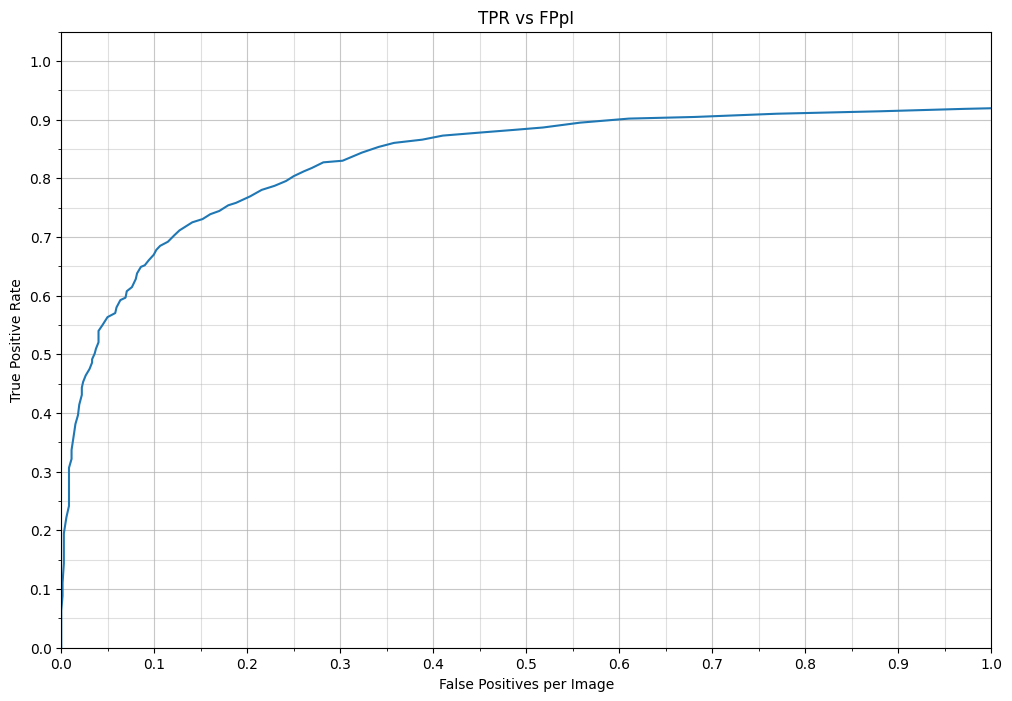

In [11]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(1, 1, 1)

ax.set_xlim(0, 1)
ax.set_ylim(0, 1.05)

ax.xaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_locator(MultipleLocator(0.1))

ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))

ax.grid(which='both')
ax.grid(which='minor', alpha=0.4)
ax.grid(which='major', alpha=0.7)

plt.plot(FPpI, tpr)
plt.xlabel("False Positives per Image")
plt.ylabel("True Positive Rate")
plt.title("TPR vs FPpI")
plt.show()

Area Under the FROC

In [14]:
# Reverse order from descending to ascending
tpr_reversed = np.flip(tpr_np)
FPpI_reversed = np.flip(FPpI_np)

def compute_auc():

    # Find the index of the element closest to 1.0
    index = np.abs(FPpI_reversed - 1.0).argmin()

    # Check if the value at the returned index is already equal to 1.0
    if FPpI_reversed[index] == 1.0:
        # Select portion of TPR and FPpI
        tpr_portion = tpr_reversed[:index+1]
        FPpI_portion = FPpI_reversed[:index+1]
    
    else:
        # Determine the closest values based on the index
        if FPpI_reversed[index] < 1.0:
            lower_index = index
            upper_index = index+1

        else:
            lower_index = index-1
            upper_index = index

        # Perform linear interpolation
        x1 = FPpI_reversed[lower_index]
        x2 = FPpI_reversed[upper_index]
        y1 = tpr_reversed[lower_index]
        y2 = tpr_reversed[upper_index]
        slope = (y2 - y1) / (x2 - x1)
        y = y1 + slope * (1.0 - x1)
        tpr_portion = tpr_reversed[:lower_index+1]
        FPpI_portion = FPpI_reversed[:lower_index+1]

        # Adding y to the end of the tpr_portion array
        tpr_portion = np.append(tpr_portion, y)
        FPpI_portion = np.append(FPpI_portion, 1.0)
        froc_auc = metrics.auc(FPpI_portion, tpr_portion)
        return froc_auc
    
print("Area under the FROC:", compute_auc())

Area under the FROC: 0.831438192412369
